In [1]:
import tensorflow as tf
import numpy as np
import os
import time

In [2]:
def return_dict(fromtext, totext):
    
    with open(fromtext, 'r') as fopen:
        fromtext = fopen.read().split('\n')
    with open(totext, 'r') as fopen:
        totext = fopen.read().split('\n')
        
    if len(fromtext) != len(totext):
        print 'from data-set must has equal length with to data-set, exiting..'
        exit(0)

    vocab_inputs = []; vocab_predict = []

    # we tokenized each sentence in both dataset, turn into vocabulary.
    for i in xrange(len(fromtext)):
        vocab_inputs += fromtext[i].split(); vocab_predict += totext[i].split()

    # Then we sorted our tokenized words from highest freq to lowest freq.
    vocab_inputs = sorted(vocab_inputs, key = vocab_inputs.count,reverse = True)
    vocab_predict = sorted(vocab_predict, key = vocab_predict.count,reverse = True)

    d1 = dict((k,v) for v,k in enumerate(reversed(vocab_inputs)))
    d2 = dict((k,v) for v,k in enumerate(reversed(vocab_predict)))

    # Then we turned our sorted words into unique words, while maintaining the position of sorting.
    vocab_inputs = ['PAD', 'EOS', 'UNK'] + sorted(d1, key = d1.get, reverse = True)
    vocab_predict = ['PAD', 'EOS', 'UNK'] + sorted(d2, key = d2.get, reverse = True)

    print 'vocab size for inputs: ' + str(len(vocab_inputs))
    print 'vocab size for predict: ' + str(len(vocab_predict))

    # Then turned into dictionary {'husein': 0, 'suka': 1.. n}
    dict_inputs = dict(zip(vocab_inputs, [i for i in xrange(len(vocab_inputs))]))
    dict_predict = dict(zip(vocab_predict, [i for i in xrange(len(vocab_predict))]))
    
    import pickle
    with open('data/vocab_inputs.p', 'wb') as fopen:
        pickle.dump(vocab_inputs, fopen)
    with open('data/vocab_predict.p', 'wb') as fopen:
        pickle.dump(vocab_predict, fopen)
    with open('data/dict_inputs.p', 'wb') as fopen:
        pickle.dump(dict_inputs, fopen)
    with open('data/dict_predict.p', 'wb') as fopen:
        pickle.dump(dict_predict, fopen)
    with open('data/fromtext.p', 'wb') as fopen:
        pickle.dump(fromtext, fopen)
    with open('data/totext.p', 'wb') as fopen:
        pickle.dump(totext, fopen)
    
    return vocab_inputs, vocab_predict, dict_inputs, dict_predict, fromtext, totext

def feed(text, length, dictionary, From = True):
    text_int = []
    if From:
        text_int_decode = [1]
    strings = text.split()
    for i in xrange(length):
        try:
            if From:
                text_int.append(dictionary[strings[i]])
                text_int_decode.append(dictionary[strings[i]])
            else:
                text_int.append(dictionary[strings[i]])
        except KeyError:
            text_int.append(2)
            if From:
                text_int_decode.append(2)
        except IndexError:
            text_int.append(0)
            if From:
                text_int_decode.append(0)
                
    text_int[length - 1] = 1
    
    if From:
        del text_int_decode[len(text_int_decode) - 1]
        return text_int, text_int_decode
    else:
        return text_int
    
def graph(LOSS):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()

    plt.plot([i for i in xrange(len(LOSS))], LOSS)
    plt.title('loss vs epoch')
    plt.show()
    
def label_to_text(label, vocab):
    string = ''
    for i in xrange(len(label)):
        if label[i] == 0 or label[i] == 1:
            continue
        string += vocab[label[i]] + ' '
    return string

In [3]:
fromtext_file = 'data/from'
totext_file = 'data/to'

length_sentence = 20
size_layers = 1024
num_layers = 1
epoch = 30
learning_rate = 0.0001

Train = True

In [4]:
class Model:
    
    def __init__(self, num_layers, size_layers, length, learning_rate, vocab_size_input, vocab_size_output):
        
        self.encoder_inputs = tf.placeholder(shape = [length], dtype = tf.int32)
        self.decoder_inputs = tf.placeholder(shape = [length], dtype = tf.int32)
        self.decoder_targets = tf.placeholder(shape = [length], dtype = tf.int32)
        
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(size_layers, activation = tf.nn.relu)

        self.cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell() for _ in xrange(num_layers)])
        
        self.outputs, _ = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(encoder_inputs = [self.encoder_inputs], 
                                                                   decoder_inputs = [self.decoder_inputs], 
                                                                   cell = self.cell, 
                                                                   num_encoder_symbols = vocab_size_input, 
                                                                   num_decoder_symbols = vocab_size_input, 
                                                                   embedding_size = size_layers)
        
        self.decoder_logits = tf.contrib.layers.linear(self.outputs, len(vocab_predict))
        self.decoder_prediction = tf.argmax(self.decoder_logits, 2)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = tf.one_hot(self.decoder_targets, depth = vocab_size_output, dtype = tf.float32), 
                                                                logits = self.decoder_logits)
        self.loss = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [5]:
import pickle

try:
    print "load embedded files.."
    with open('data/vocab_inputs.p', 'rb') as fopen:
        vocab_inputs = pickle.load(fopen)
    with open('data/vocab_predict.p', 'rb') as fopen:
        vocab_predict = pickle.load(fopen)
    with open('data/dict_inputs.p', 'rb') as fopen:
        dict_inputs = pickle.load(fopen)
    with open('data/dict_predict.p', 'rb') as fopen:
        dict_predict = pickle.load(fopen)
    with open('data/fromtext.p', 'rb') as fopen:
        fromtext = pickle.load(fopen)
    with open('data/totext.p', 'rb') as fopen:
        totext = pickle.load(fopen)
    print 'done load embedded files'
except Exception as e:
    print str(e) + ', processing embedded files, this might takes several minutes'
    vocab_inputs, vocab_predict, dict_inputs, dict_predict, fromtext, totext = return_dict(fromtext_file, totext_file)

sess = tf.InteractiveSession()
model = Model(num_layers, size_layers, length_sentence, learning_rate, len(vocab_inputs), len(vocab_predict))
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.global_variables())
location = os.getcwd()

load embedded files..
done load embedded files


In [6]:
def randomtest():
    import random
    randomselect = random.randint(30, 100)
    for i in xrange(randomselect):
        num = random.randint(0, len(fromtext) - 1)
        input_seq_encode, input_seq_decode = feed(fromtext[num], length_sentence, dict_inputs, True)
        predict = sess.run(model.decoder_prediction, feed_dict = {model.encoder_inputs : input_seq_encode, model.decoder_inputs : input_seq_decode})
        print 'sentence: ' + str(i + 1)
        print 'input: ' + fromtext[num]
        print 'predict respond: ' + str(label_to_text(predict[0, :], vocab_predict))
        print 'actual respond: ' + totext[num] + '\n'

def test():
    sentence = raw_input('> ')
    while sentence:
        input_seq_encode, input_seq_decode = feed(sentence, length_sentence, dict_inputs, True)
        predict = sess.run(model.decoder_prediction, feed_dict = {model.encoder_inputs : input_seq_encode, model.decoder_inputs : input_seq_decode})
        print label_to_text(predict[0, :], vocab_predict)
        sentence = raw_input('> ')
        
def train():
    LOSS = []
    for i in xrange(epoch):
        total_loss = 0
        lasttime = time.time()
        for w in xrange(len(fromtext)):
            input_seq_encode, input_seq_decode = feed(fromtext[w], length_sentence, dict_inputs, True)
            output_seq = feed(totext[w], length_sentence, dict_predict, False)
            _, losses = sess.run([model.optimizer, model.loss], feed_dict = {model.encoder_inputs : input_seq_encode, model.decoder_inputs : input_seq_decode, 
                                                                 model.decoder_targets : output_seq })
            total_loss += losses
            
            if (w + 1) % 200 == 0:
                print 'done process: ' + str(w + 1)
                
        total_loss = total_loss / (len(fromtext) * 1.0)
        LOSS.append(total_loss)
        print 'epoch: ' + str(i + 1) + ', total loss: ' + str(total_loss) + ', s/epoch: ' + str(time.time() - lasttime)
        saver.save(sess, location + "/model.ckpt")
    graph(LOSS)
    randomtest()

done process: 200
done process: 400
done process: 600
epoch: 1, total loss: 1.39197879303, s/epoch: 39.6266481876
done process: 200
done process: 400
done process: 600
epoch: 2, total loss: 1.12367172805, s/epoch: 39.450838089
done process: 200
done process: 400
done process: 600
epoch: 3, total loss: 0.942006279869, s/epoch: 39.4433028698
done process: 200
done process: 400
done process: 600
epoch: 4, total loss: 0.771754278118, s/epoch: 39.4305529594
done process: 200
done process: 400
done process: 600
epoch: 5, total loss: 0.662924866127, s/epoch: 39.3509840965
done process: 200
done process: 400
done process: 600
epoch: 6, total loss: 0.609594779034, s/epoch: 39.3231899738
done process: 200
done process: 400
done process: 600
epoch: 7, total loss: 0.573206361217, s/epoch: 39.3578619957
done process: 200
done process: 400
done process: 600
epoch: 8, total loss: 0.539124352264, s/epoch: 39.3337221146
done process: 200
done process: 400
done process: 600
epoch: 9, total loss: 0.50715

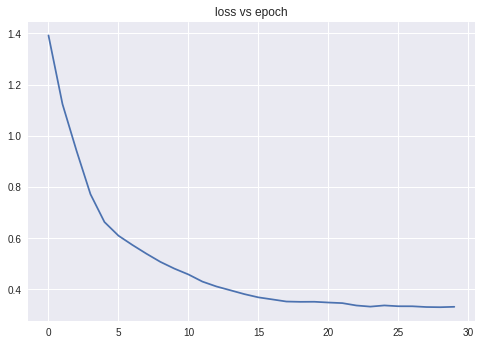

sentence: 1
input: bernama The Company
predict respond: Keadaan tidak 
actual respond: Keadaan tidak baik Awak?

sentence: 2
input: Ruparupanya awak boleh
predict respond: Dia pulihkan akan 
actual respond: Dia cakap dia dapat lihat

sentence: 3
input: Tuang ke dalam tandas
predict respond: Apabila kita melihat keunikan kita 
actual respond: Apabila kita melihat keunikan kita

sentence: 4
input: Saya boleh lakukan ini!
predict respond: kesunyian maksud kau 
actual respond: Itulah maksud aku

sentence: 5
input: Negara tunggu awak
predict respond: Jadi, bagaimana sekarang? 
actual respond: Jadi, bagaimana sekarang?

sentence: 6
input: bukan kerana kita sependapat
predict respond: Di dalam itu 
actual respond: Di dalam itu

sentence: 7
input: Jawab saya
predict respond: Saya tahu 
actual respond: Saya tahu

sentence: 8
input: bunuh orang yang membelot
predict respond: Biar saya fahamkan 
actual respond: Biar saya cuba fahamkan

sentence: 9
input: Ya, dia juga pernah kata,
predict respond:

In [7]:
def main():
    if Train:
        train()
    else:
        randomtest()
        
main()